In [1]:
# script to generate 20 mechanisms with the top 20 parameters to include

# generate the lists of top parameters

In [2]:
import os
import sys
import copy
import pickle
import subprocess

import numpy as np
import rmgpy.chemkin

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
basedir = '/home/moon/autoscience/autoscience/butane/models/rmg_model'

base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)




In [3]:
# get most uncertain reactions
covariance_file = '/home/moon/autoscience/autoscience/uncertainty/butane_covariance.pickle'
with open(covariance_file, 'rb') as handle:
    Sigma_k = pickle.load(handle)
uncorrelated_uncertainties = np.diagonal(Sigma_k)

reaction_indices = np.arange(0, len(reaction_list))
reaction_uncertainty_order = [x for _,x in sorted(zip(uncorrelated_uncertainties, reaction_indices))][::-1]

In [4]:
# get most sensitive reactions
base_delay = 0.14857535
reaction_delay_file = '/home/moon/autoscience/autoscience/butane/sensitivity_analysis/base_rmg24/reaction_ignition_delays_raw.npy'
reaction_delays_raw = np.load(reaction_delay_file)
reaction_sensitivities = ((reaction_delays_raw - base_delay) / base_delay) / 0.1

reaction_sensitivity_order = [x for _,x in sorted(zip(np.abs(reaction_sensitivities), reaction_indices))][::-1]


In [5]:
# Calculate Improvement Score
DFT_error = 3.0
improvement_score = np.abs(reaction_sensitivities) * (uncorrelated_uncertainties - DFT_error)
improvement_score_order = [x for _,x in sorted(zip(improvement_score, reaction_indices))][::-1]


In [6]:
# get most uncertain species
species_uncertainty = '/home/moon/autoscience/autoscience/paper/models/base_rmg/thermo_uncertainty.npy'
species_indices = np.arange(0, len(reaction_list))
uncorrelated_species_uncertainties = np.load(species_uncertainty)
species_uncertainty_order = [x for _,x in sorted(zip(uncorrelated_species_uncertainties, species_indices))][::-1]

In [7]:
# get most sensitive species
base_delay = 0.14857535
species_delay_file = '/home/moon/autoscience/autoscience/butane/sensitivity_analysis/base_rmg24/species_ignition_delays_raw.npy'
species_delays_raw = np.load(species_delay_file)
species_sensitivities = ((species_delays_raw - base_delay) / base_delay) / 0.1

species_sensitivity_order = [x for _,x in sorted(zip(np.abs(species_sensitivities), species_indices))][::-1]


In [8]:
# Calculate Improvement Score
DFT_error = 3.0
species_improvement_score = np.abs(species_sensitivities) * (uncorrelated_species_uncertainties - DFT_error)
species_improvement_score_order = [x for _,x in sorted(zip(species_improvement_score, species_indices))][::-1]

In [9]:
# concatenate species then reactions to sort total
total_sensitivities = np.concatenate((species_sensitivities, reaction_sensitivities))
total_uncertainties = np.concatenate((uncorrelated_species_uncertainties, uncorrelated_uncertainties))
total_indices = np.arange(0, len(species_list) + len(reaction_list))


total_improvement_score = np.abs(total_sensitivities) * (total_uncertainties - DFT_error)
total_improvement_score_order = [x for _,x in sorted(zip(total_improvement_score, total_indices))][::-1]


In [11]:
total_improvement_score_order[0]

87

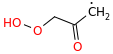

In [4]:
species_list[87]

In [12]:
total_improvement_score_order[3]

434

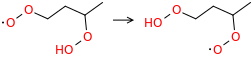

In [5]:
reaction_list[324]

In [13]:
total_improvement_score_order[8]

1398

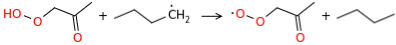

In [6]:
reaction_list[1288]

In [16]:
total_improvement_score_order[31]

1824

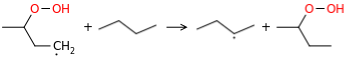

In [7]:
reaction_list[1714]

# Generate the Mechanisms

In [17]:
save_dir = '/home/moon/autoscience/autoscience/paper/error_vs_num_included'
# for e in range(0, 51):

# load the base mechanism
basedir = '/home/moon/autoscience/autoscience/butane/models/rmg_model'
base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)

# Load the new kinetics library
#     DFT_DIR = "/work/westgroup/harris.se/autoscience/autoscience/butane/dft/"
DFT_DIR = "/home/moon/autoscience/autoscience/butane/dft/"
kinetics_lib = os.path.join(DFT_DIR, 'kinetics', 'kinetics')
ark_kinetics_database = rmgpy.data.kinetics.KineticsDatabase()
ark_kinetics_database.load_libraries(kinetics_lib)
print(f'{len(ark_kinetics_database.libraries[""].entries)} kinetics entries loaded')

# Load the new thermo library
thermo_lib = os.path.join(DFT_DIR, 'thermo', 'thermo')
ark_thermo_database = rmgpy.data.thermo.ThermoDatabase()
ark_thermo_database.load_libraries(thermo_lib)
print(f'{len(ark_thermo_database.libraries["harris_butane"].entries)} thermo entries loaded')


species_change_list = [87]
reaction_change_list = [324, 1288, 1714]

# change relevant kinetics
total_changed = 0
for key in ark_kinetics_database.libraries[''].entries.keys():
    entry = ark_kinetics_database.libraries[''].entries[key]
    index = entry.index
    for i in range(0, len(reaction_list)):
        if entry.item.is_isomorphic(reaction_list[i]):
            rmg_rxn_index = i
            break
    else:  
        print(f'could not match reaction index {index}')
        continue

    if rmg_rxn_index in reaction_change_list:
        print(f'changing reaction {rmg_rxn_index} {reaction_list[rmg_rxn_index]}')
        reaction_list[rmg_rxn_index].kinetics = entry.data
        total_changed += 1
print(total_changed, 'kinetics changed')


# change the relevant thermo
sp_changed = 0
for key in ark_thermo_database.libraries['harris_butane'].entries.keys():
    entry = ark_thermo_database.libraries['harris_butane'].entries[key]

    for i, species in enumerate(species_list):
        if entry.item.smiles == species.smiles:
            rmg_species_index = i
            break
    else:
        entry_sp = rmgpy.species.Species(smiles=entry.item.smiles)
        for j, species in enumerate(species_list):
            if entry_sp.is_isomorphic(species.molecule[0]):
                rmg_species_index = i
                'matched'
                break
        else:
            continue
            raise ValueError (f'could not match species index {entry}')

    if rmg_species_index in species_change_list:
        print(f'Changing estimated thermo {rmg_species_index}: {species_list[rmg_species_index]}')
        species_list[rmg_species_index].thermo = entry.data

        sp_changed += 1

print(sp_changed, 'species changed')

# export the mechanism
chemkin_file = os.path.join(save_dir, f'change4.inp')
rmgpy.chemkin.save_chemkin_file(chemkin_file, species_list, reaction_list, verbose=True, check_for_duplicates=True)
subprocess.run(['ck2cti', f'--input={chemkin_file}', f'--transport={transport}', f'--output={chemkin_file[:-4]}.cti'])
subprocess.run(['ck2yaml', f'--input={chemkin_file}', f'--transport={transport}', f'--output={chemkin_file[:-4]}.yaml'])

129 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 1288 C3KET21(73) + PC4H9(182) <=> CH3COCH2O2(72) + butane(1)
changing reaction 1714 C4H8OOH2-4(223) + butane(1) <=> SC4H9(183) + SC4H9O2H(187)
could not match reaction index 2014
could not match reaction index 2474
could not match reaction index 2477
could not match reaction index 2478
could not match reaction index 2479
could not match reaction index 2486
could not match reaction index 2488
could not match reaction index 2489
could not match reaction index 2492
could not match reaction index 2494
could not match reaction index 2495
could not match reaction index 2496
could not match reaction index 2497
could not match reaction index 2499
could not match reaction index 2500
could not match reaction index 2507
could not match reaction index 2566
3 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)


1 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/autoscience/paper/error_vs_num_included/change4.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/autoscience/paper/error_vs_num_included/change4.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED


CompletedProcess(args=['ck2yaml', '--input=/home/moon/autoscience/autoscience/paper/error_vs_num_included/change4.inp', '--transport=/home/moon/autoscience/autoscience/butane/models/rmg_model/tran.dat', '--output=/home/moon/autoscience/autoscience/paper/error_vs_num_included/change4.yaml'], returncode=0)